In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.model_selection import ParameterGrid

from recsys4daos.models import NLPSimilarity
from recsys4daos.utils import Timer
from recsys4daos.datasets import to_microsoft
from recsys4daos.evaluation import calculate_all_metrics
from recsys4daos.model_selection import cvtt_open, explore_hparams

import paths

import seaborn as sns
sns.set_theme()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/home/daviddavo/recsys4daos/.direnv/python-3.11/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Parameters

In [2]:
# Dataset config
ORG_NAME = 'Decentraland'

# Evaluation
K_RECOMMENDATIONS: list[int] = [1,3,5,10,15,100]
SPLITS_FREQ: str = 'W-THU' # split weekly
SPLITS_NORMALIZE = True # Wether or not to move everything to 00:00
LAST_FOLDS = 10 # Use just last 10 splits
LAST_FOLD_DATE_STR: str = None

# Search space config
WINDOW_SIZES = ['7d', '14d', '21d', '30d', '60d', '90d', '10YE']
MODEL_NAMES = [
    'all-mpnet-base-v2', # The one used in sbert's examples
    'all-distilroberta-v1',
    'all-MiniLM-L12-v2',
    'all-MiniLM-L6-v2',
]

OPTIM_METRIC = 'map@10'

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
ORG_NAME = "SharkDAO"
SPLITS_FREQ = "3d"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2022-04-27"


In [4]:
EMBEDDINGS_CACHE = Path(paths.DEFAULT_CACHE_PATH) / 'pln-embeddings'

# Load the dataset

In [5]:
dfp = paths.load_proposals(ORG_NAME, text=True)
dfv = paths.load_votes(ORG_NAME)

print(dfp.info())
print(dfv.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471 entries, 0 to 470
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 471 non-null    object        
 1   author             471 non-null    object        
 2   date               471 non-null    datetime64[us]
 3   start              471 non-null    datetime64[us]
 4   end                471 non-null    datetime64[us]
 5   platform_proposal  471 non-null    object        
 6   title              471 non-null    object        
 7   description        471 non-null    object        
dtypes: datetime64[us](3), object(5)
memory usage: 29.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7577 entries, 0 to 7576
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        7577 non-null   object        
 1   proposal  7577 non-null   object

In [6]:
df = to_microsoft(dfv)
df

,userID,itemID,timestamp,rating
0,0xde30040413b26d7aa2b6fc4761d80eb35dcf97ad,71fd3375-6164-5810-a77c-2279e0a7a93d,2021-08-09 23:44:27,1
1,0x823b92d6a4b2aed4b15675c7917c9f922ea8adad,71fd3375-6164-5810-a77c-2279e0a7a93d,2021-08-09 23:44:52,1
2,0x397fbd1e27352175cc5b6baf171a30911268823c,71fd3375-6164-5810-a77c-2279e0a7a93d,2021-08-09 23:48:54,1
3,0x40b6df5f6217fb1a1beaf8fdbb9572304aa78c4d,71fd3375-6164-5810-a77c-2279e0a7a93d,2021-08-09 23:49:58,1
4,0xf33364a83b6002d5070ec5fa31f5d9eb93572732,86ab69e0-1e59-5d8a-90d0-33c00a5934b2,2021-08-10 00:09:04,1
...,...,...,...,...
7572,0xe3f27deff96fe178e87559f36cbf868b9e75967d,51c2826f-fced-5e49-8746-5bbed3d189f5,2023-07-19 15:21:54,1
7573,0xbd7dbab9aeb52d6c8d0e80fcebde3af4cc86204a,be6c0ebe-be38-52d6-b766-c55b7489f245,2023-07-20 18:25:20,1
7574,0xbd7dbab9aeb52d6c8d0e80fcebde3af4cc86204a,ac915362-a23d-5498-9f08-38bbbf0a8bbc,2023-07-20 18:26:23,1
7575,0xbd7dbab9aeb52d6c8d0e80fcebde3af4cc86204a,dfa74f32-39e0-5609-8e00-a821f32f8ef2,2023-07-20 18:27:16,1


## Split in folds

In [7]:
all_folds = { f.end:f for f in cvtt_open(
    df, SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', last_fold=LAST_FOLD_DATE_STR,
)}
last_folds_idx = list(all_folds.keys())[-LAST_FOLDS:]
last_folds_idx

[Timestamp('2022-03-31 00:00:00'),
 Timestamp('2022-04-03 00:00:00'),
 Timestamp('2022-04-06 00:00:00'),
 Timestamp('2022-04-09 00:00:00'),
 Timestamp('2022-04-12 00:00:00'),
 Timestamp('2022-04-15 00:00:00'),
 Timestamp('2022-04-18 00:00:00'),
 Timestamp('2022-04-21 00:00:00'),
 Timestamp('2022-04-24 00:00:00'),
 Timestamp('2022-04-27 00:00:00')]

# Similarity PLN

In [8]:
def testHParamsPLNSimilarity(fold, window_size, model_name):
    f = all_folds[fold]
    
    model = NLPSimilarity(dfp, EMBEDDINGS_CACHE, model_name=model_name)

    offset = pd.tseries.frequencies.to_offset(window_size)
    train = f.train[f.train['timestamp'] > (f.end - offset)]

    with Timer() as t_fit:
        model.fit(train)

    with Timer() as t_rec:
        # Truncate the top_k
        top_k = max(K_RECOMMENDATIONS)
        users = np.intersect1d(f.test['userID'].unique(), train['userID'].unique())
        recs = model.recommend_k_items(users, top_k=min(len(f.open_proposals), top_k), recommend_from=f.open_proposals)
    
    return {
        'time_train': t_fit.time,
        'time_rec': t_rec.time,
        'rec_users': len(users),
        **calculate_all_metrics(f.test, recs, K_RECOMMENDATIONS),
    }

# testHParamsPLNSimilarity(last_folds_idx[0], '14D', MODEL_NAMES[0])

In [9]:
# Populate the cache of embeddings for each model
from recsys4daos.models.nlp import NLPModel

for m in MODEL_NAMES:
    NLPModel(dfp, EMBEDDINGS_CACHE, model_name=m).fit()

In [10]:
results = explore_hparams(
    testHParamsPLNSimilarity,
    ParameterGrid({
        'fold': last_folds_idx,
        'model_name': MODEL_NAMES,
        'window_size': WINDOW_SIZES,
    }),
    paths.hparams_progress('pln-similarity', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE),
)
mdf = pd.DataFrame(results)
mdf

Restored checkpoint from ../.cache/SharkDAO/hparams-pln-similarity_3d_normalize.pkl with 560 results


  0%|          | 0/280 [00:00<?, ?it/s]

,fold,model_name,window_size,time_train,time_rec,rec_users,precision@1,precision@3,precision@5,precision@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
0,2022-04-03,all-mpnet-base-v2,7d,0.081357,0.001366,16,0.437500,0.375000,0.225000,0.112500,...,1.0,1.0,1.0,0.904762,1.000000,1.000000,1.000000,1.000000,1.000000,0.132228
1,2022-04-03,all-mpnet-base-v2,14d,0.082816,0.001346,20,0.450000,0.366667,0.220000,0.110000,...,1.0,1.0,1.0,0.925926,1.000000,1.000000,1.000000,1.000000,1.000000,0.130397
2,2022-04-03,all-mpnet-base-v2,21d,0.230508,0.001330,21,0.523810,0.396825,0.238095,0.119048,...,1.0,1.0,1.0,0.878788,1.000000,1.000000,1.000000,1.000000,1.000000,0.125676
3,2022-04-03,all-mpnet-base-v2,30d,0.084655,0.001363,24,0.416667,0.416667,0.250000,0.125000,...,1.0,1.0,1.0,0.800000,1.000000,1.000000,1.000000,1.000000,1.000000,0.127614
4,2022-04-03,all-mpnet-base-v2,60d,0.235632,0.001332,26,0.461538,0.423077,0.253846,0.126923,...,1.0,1.0,1.0,0.833333,0.961538,0.961538,0.961538,0.961538,0.961538,0.126141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,2022-03-31,all-MiniLM-L6-v2,21d,0.071303,0.001153,5,1.000000,0.333333,0.200000,0.100000,...,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.122819
276,2022-03-31,all-MiniLM-L6-v2,30d,0.235335,0.001086,6,1.000000,0.333333,0.200000,0.100000,...,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.121650
277,2022-03-31,all-MiniLM-L6-v2,60d,0.079867,0.001192,8,1.000000,0.333333,0.200000,0.100000,...,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.126267
278,2022-03-31,all-MiniLM-L6-v2,90d,0.253427,0.001156,10,1.000000,0.333333,0.200000,0.100000,...,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.122422


<Axes: xlabel='window_size', ylabel='map@10'>

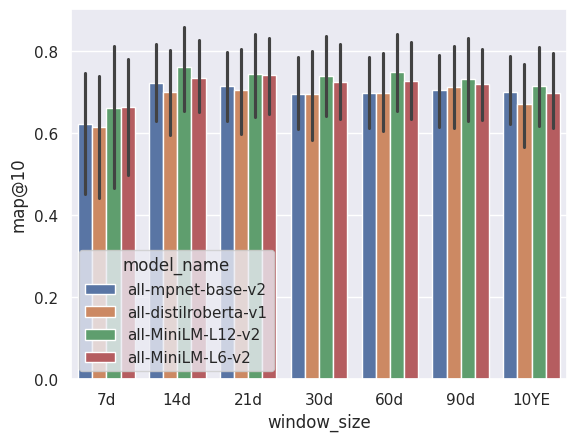

In [11]:
sns.barplot(mdf, x='window_size', y=OPTIM_METRIC, hue='model_name')

## Best overall hparams

In [12]:
display_columns = ['time_train'] + [ c for c in mdf.columns if c.endswith('@5') or c.endswith('@10') or c.endswith('@100') ]
hparam_cols = ['window_size', 'model_name']
overall_hparams = mdf[mdf['fold'] > last_folds_idx[0]].groupby(hparam_cols).mean().sort_values(OPTIM_METRIC, ascending=False)
overall_hparams[display_columns]

time_train  precision@5  precision@10  \
window_size model_name                                                    
7d          all-MiniLM-L6-v2        0.152381     0.350839      0.185605   
            all-MiniLM-L12-v2       0.170801     0.352074      0.185605   
14d         all-MiniLM-L12-v2       0.155530     0.352916      0.187513   
60d         all-MiniLM-L12-v2       0.147495     0.354002      0.189001   
21d         all-MiniLM-L12-v2       0.140790     0.351780      0.187408   
            all-MiniLM-L6-v2        0.141294     0.353323      0.187408   
30d         all-MiniLM-L12-v2       0.210033     0.348661      0.186213   
14d         all-MiniLM-L6-v2        0.172143     0.353926      0.187513   
90d         all-MiniLM-L12-v2       0.186011     0.348249      0.186799   
60d         all-MiniLM-L6-v2        0.129520     0.360669      0.189001   
30d         all-MiniLM-L6-v2        0.191604     0.351439      0.186213   
14d         all-mpnet-base-v2       0.185649     0.355497      0.187513   
7d          all-mpnet-base-v2       0.150171     0.351611      0.185605   
90d         all-MiniLM-L6-v2        0.185312     0.357582      0.186799   
7d          all-distilroberta-v1    0.151481     0.357629      0.185605   
21d         all-mpnet-base-v2       0.171174     0.356550      0.187408   
10YE        all-MiniLM-L12-v2       0.325954     0.342896      0.183459   
90d         all-distilroberta-v1    0.168170     0.357582      0.186799   
            all-mpnet-base-v2       0.200745     0.356385      0.186799   
21d         all-distilroberta-v1    0.173639     0.356718      0.187408   
14d         all-distilroberta-v1    0.189762     0.358079      0.187513   
10YE        all-mpnet-base-v2       0.353405     0.347862      0.183459   
60d         all-distilroberta-v1    0.196299     0.359780      0.189001   
10YE        all-MiniLM-L6-v2        0.323967     0.346519      0.183459   
60d         all-mpnet-base-v2       0.195098     0.358299      0.189001   
30d         all-distilroberta-v1    0.174759     0.354834      0.186213   
            all-mpnet-base-v2       0.173005     0.355143      0.186213   
10YE        all-distilroberta-v1    0.372078     0.346160      0.183459   

                                  precision@100    ndcg@5   ndcg@10  ndcg@100  \
window_size model_name                                                          
7d          all-MiniLM-L6-v2           0.018560  0.437241  0.450960  0.450960   
            all-MiniLM-L12-v2          0.018560  0.432737  0.444537  0.444537   
14d         all-MiniLM-L12-v2          0.018751  0.568701  0.582185  0.582185   
60d         all-MiniLM-L12-v2          0.018900  0.674805  0.692705  0.692705   
21d         all-MiniLM-L12-v2          0.018741  0.579768  0.595489  0.595489   
            all-MiniLM-L6-v2           0.018741  0.583784  0.598168  0.598168   
30d         all-MiniLM-L12-v2          0.018621  0.609433  0.626085  0.626085   
14d         all-MiniLM-L6-v2           0.018751  0.558019  0.571738  0.571738   
90d         all-MiniLM-L12-v2          0.018680  0.700272  0.720288  0.720288   
60d         all-MiniLM-L6-v2           0.018900  0.666134  0.676702  0.676702   
30d         all-MiniLM-L6-v2           0.018621  0.606603  0.620987  0.620987   
14d         all-mpnet-base-v2          0.018751  0.552978  0.565893  0.565893   
7d          all-mpnet-base-v2          0.018560  0.418655  0.431454  0.431454   
90d         all-MiniLM-L6-v2           0.018680  0.702621  0.711917  0.711917   
7d          all-distilroberta-v1       0.018560  0.419986  0.429736  0.429736   
21d         all-mpnet-base-v2          0.018741  0.568128  0.581110  0.581110   
10YE        all-MiniLM-L12-v2          0.018346  0.750716  0.772095  0.772095   
90d         all-distilroberta-v1       0.018680  0.692419  0.703591  0.703591   
            all-mpnet-base-v2          0.018680  0.685357  0.700037  0.700037   
21d         all-distilroberta-v1       0.018741  0.561462  0.572881  0.572881   
1

In [13]:
best_avg_hparams = mdf.set_index(hparam_cols).loc[overall_hparams.iloc[0].name].reset_index().set_index(['fold', *hparam_cols])
paths.save_model_results(best_avg_hparams, 'plnsim-best-avg', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
best_avg_hparams

Saved dataframe into /home/daviddavo/recsys4daos/data/output/SharkDAO/models/plnsim-best-avg_3d_normalize.parquet


/tmp/ipykernel_3831108/971293119.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  best_avg_hparams = mdf.set_index(hparam_cols).loc[overall_hparams.iloc[0].name].reset_index().set_index(['fold', *hparam_cols])


,,,time_train,time_rec,rec_users,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
fold,window_size,model_name,,,,,,,,,,,,,,,,,,,,,
2022-04-03,7d,all-MiniLM-L6-v2,0.210577,0.001334,16,0.625000,0.375000,0.225000,0.112500,0.075000,0.011250,0.333333,...,1.0,1.0,1.0,0.933333,1.000000,1.000000,1.000000,1.000000,1.000000,0.124871
2022-04-06,7d,all-MiniLM-L6-v2,0.216127,0.001224,5,0.800000,0.400000,0.240000,0.120000,0.080000,0.012000,0.444444,...,1.0,1.0,1.0,0.875000,1.000000,1.000000,1.000000,1.000000,1.000000,0.123777
2022-04-09,7d,all-MiniLM-L6-v2,0.069518,0.001280,11,0.727273,0.545455,0.327273,0.163636,0.109091,0.016364,0.320000,...,1.0,1.0,1.0,0.729167,0.850000,0.850000,0.850000,0.850000,0.850000,0.125393
2022-04-12,7d,all-MiniLM-L6-v2,0.068111,0.001278,10,0.600000,0.466667,0.400000,0.200000,0.133333,0.020000,0.315789,...,1.0,1.0,1.0,0.444444,0.805556,0.805556,0.805556,0.805556,0.805556,0.125660
2022-04-15,7d,all-MiniLM-L6-v2,0.224727,0.001312,18,0.555556,0.425926,0.344444,0.227778,0.151852,0.022778,0.384615,...,1.0,1.0,1.0,0.495000,0.681944,0.736111,0.736111,0.736111,0.736111,0.127881
2022-04-18,7d,all-MiniLM-L6-v2,0.218425,0.001096,4,0.750000,0.583333,0.350000,0.175000,0.116667,0.017500,0.333333,...,1.0,1.0,1.0,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.124831
2022-04-21,7d,all-MiniLM-L6-v2,0.070891,0.001281,9,0.555556,0.518519,0.466667,0.244444,0.162963,0.024444,0.333333,...,1.0,1.0,1.0,0.513333,0.740000,0.966667,1.000000,1.000000,1.000000,0.125961
2022-04-24,7d,all-MiniLM-L6-v2,0.221766,0.001309,16,0.375000,0.333333,0.337500,0.193750,0.129167,0.019375,0.285714,...,1.0,1.0,1.0,0.416667,0.678571,0.750000,0.750000,0.750000,0.750000,0.127168
2022-04-27,7d,all-MiniLM-L6-v2,0.071288,0.001272,6,0.666667,0.500000,0.466667,0.233333,0.155556,0.023333,0.333333,...,1.0,1.0,1.0,0.625000,0.766667,0.866667,0.866667,0.866667,0.866667,0.125173


## best hparams by fold

In [14]:
print("Best hyperparams by fold", OPTIM_METRIC)
best_hparams = mdf.sort_values(OPTIM_METRIC,ascending=False).drop_duplicates(['fold'], keep='first').sort_values('fold').set_index(['fold', 'model_name', 'window_size'])
paths.save_model_results(best_hparams, 'plnsim-best-val', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
best_hparams[display_columns]

Best hyperparams by fold map@10
Saved dataframe into /home/daviddavo/recsys4daos/data/output/SharkDAO/models/plnsim-best-val_3d_normalize.parquet


,,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
fold,model_name,window_size,,,,,,,,,,,,,,,,
2022-03-31,all-MiniLM-L6-v2,10YE,0.240009,0.200000,0.100000,0.010000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000
2022-04-03,all-MiniLM-L12-v2,30d,0.229642,0.250000,0.125000,0.012500,0.783333,0.783333,0.783333,0.972222,0.972222,0.972222,1.000000,1.0,1.0,1.000000,1.000000,1.000000
2022-04-06,all-MiniLM-L6-v2,14d,0.070607,0.233333,0.116667,0.011667,0.625659,0.625659,0.625659,0.916667,0.916667,0.916667,1.000000,1.0,1.0,1.000000,1.000000,1.000000
2022-04-09,all-MiniLM-L6-v2,7d,0.069518,0.327273,0.163636,0.016364,0.397500,0.397500,0.397500,0.863636,0.863636,0.863636,1.000000,1.0,1.0,0.850000,0.850000,0.850000
2022-04-12,all-mpnet-base-v2,7d,0.081566,0.400000,0.200000,0.020000,0.448371,0.448371,0.448371,0.786667,0.786667,0.786667,1.000000,1.0,1.0,0.777778,0.777778,0.777778
2022-04-15,all-distilroberta-v1,7d,0.083525,0.455556,0.227778,0.022778,0.571299,0.571299,0.571299,0.746296,0.746296,0.746296,1.000000,1.0,1.0,0.773810,0.773810,0.773810
2022-04-18,all-MiniLM-L12-v2,60d,0.080250,0.325000,0.162500,0.016250,0.788734,0.788734,0.788734,0.812500,0.812500,0.812500,1.000000,1.0,1.0,0.642857,0.642857,0.642857
2022-04-21,all-distilroberta-v1,21d,0.090303,0.563636,0.309091,0.030909,0.634915,0.634915,0.634915,0.818182,0.818182,0.818182,0.954545,1.0,1.0,0.928571,1.000000,1.000000
2022-04-24,all-MiniLM-L6-v2,7d,0.221766,0.337500,0.193750,0.019375,0.474595,0.504074,0.504074,0.495399,0.530618,0.530618,0.921875,1.0,1.0,0.750000,0.750000,0.750000


In [15]:
best_hparams.describe()[display_columns]

,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.0,10.000000,10.000000,10.000000
mean,0.123871,0.355896,0.183176,0.018318,0.615105,0.618052,0.618052,0.821805,0.825327,0.825327,0.987642,1.0,1.0,0.865635,0.872778,0.872778
std,0.073965,0.115448,0.063500,0.006350,0.194202,0.192044,0.192044,0.141004,0.132104,0.132104,0.027167,0.0,0.0,0.125655,0.131523,0.131523
min,0.069518,0.200000,0.100000,0.010000,0.397500,0.397500,0.397500,0.495399,0.530618,0.530618,0.921875,1.0,1.0,0.642857,0.642857,0.642857
25%,0.073707,0.268750,0.134375,0.013438,0.454927,0.462297,0.462297,0.791620,0.791620,0.791620,1.000000,1.0,1.0,0.774802,0.774802,0.774802
50%,0.082545,0.332386,0.178693,0.017869,0.598479,0.598479,0.598479,0.815341,0.815341,0.815341,1.000000,1.0,1.0,0.889286,0.891667,0.891667
75%,0.188900,0.441667,0.220833,0.022083,0.746229,0.746229,0.746229,0.903409,0.903409,0.903409,1.000000,1.0,1.0,0.983333,1.000000,1.000000
max,0.240009,0.563636,0.309091,0.030909,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000


### Results of using best hparams on next fold

In [16]:
next_hparams_idx = best_hparams.index.to_frame(False)
next_hparams_idx['fold'] = next_hparams_idx['fold'].shift(-1)
next_hparams_idx = next_hparams_idx.dropna()
assert len(next_hparams_idx) == len(best_hparams)-1
next_hparams = mdf.set_index(['fold', 'model_name', 'window_size']).loc[pd.MultiIndex.from_frame(next_hparams_idx)]
paths.save_model_results(next_hparams, 'plnsim-best-test', ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, K_RECOMMENDATIONS)
next_hparams[display_columns]

Saved dataframe into /home/daviddavo/recsys4daos/data/output/SharkDAO/models/plnsim-best-test_3d_normalize.parquet


,,,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
fold,model_name,window_size,,,,,,,,,,,,,,,,
2022-04-03,all-MiniLM-L6-v2,10YE,0.382147,0.253333,0.126667,0.012667,0.794236,0.794236,0.794236,0.722222,0.722222,0.722222,1.000000,1.0,1.0,0.937500,0.937500,0.937500
2022-04-06,all-MiniLM-L12-v2,30d,0.223268,0.233333,0.116667,0.011667,0.584651,0.584651,0.584651,0.833333,0.833333,0.833333,1.000000,1.0,1.0,1.000000,1.000000,1.000000
2022-04-09,all-MiniLM-L6-v2,14d,0.220090,0.362500,0.181250,0.018125,0.550474,0.550474,0.550474,0.807292,0.807292,0.807292,1.000000,1.0,1.0,0.846154,0.846154,0.846154
2022-04-12,all-MiniLM-L6-v2,7d,0.068111,0.400000,0.200000,0.020000,0.411798,0.411798,0.411798,0.683611,0.683611,0.683611,1.000000,1.0,1.0,0.805556,0.805556,0.805556
2022-04-15,all-mpnet-base-v2,7d,0.082096,0.411111,0.227778,0.022778,0.475488,0.505147,0.505147,0.576389,0.613426,0.613426,0.907407,1.0,1.0,0.727273,0.727273,0.727273
2022-04-18,all-distilroberta-v1,7d,0.237044,0.350000,0.175000,0.017500,0.286698,0.286698,0.286698,0.520833,0.520833,0.520833,1.000000,1.0,1.0,0.500000,0.500000,0.500000
2022-04-21,all-MiniLM-L12-v2,60d,0.233366,0.533333,0.291667,0.029167,0.625671,0.625671,0.625671,0.708333,0.708333,0.708333,0.958333,1.0,1.0,0.916667,1.000000,1.000000
2022-04-24,all-distilroberta-v1,21d,0.242865,0.266667,0.183333,0.018333,0.362174,0.456544,0.456544,0.295756,0.373358,0.373358,0.731481,1.0,1.0,0.566667,0.566667,0.566667
2022-04-27,all-MiniLM-L6-v2,7d,0.071288,0.466667,0.233333,0.023333,0.422215,0.422215,0.422215,0.788889,0.788889,0.788889,1.000000,1.0,1.0,0.866667,0.866667,0.866667


In [17]:
next_hparams.describe()[display_columns]

,time_train,precision@5,precision@10,precision@100,ndcg@5,ndcg@10,ndcg@100,map@5,map@10,map@100,recall@5,recall@10,recall@100,r-precision@5,r-precision@10,r-precision@100
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.0,9.0,9.000000,9.000000,9.000000
mean,0.195586,0.364105,0.192855,0.019285,0.501490,0.515271,0.515271,0.659629,0.672366,0.672366,0.955247,1.0,1.0,0.796276,0.805535,0.805535
std,0.103763,0.101071,0.054086,0.005409,0.154510,0.146298,0.146298,0.171080,0.148930,0.148930,0.089712,0.0,0.0,0.169090,0.178525,0.178525
min,0.068111,0.233333,0.116667,0.011667,0.286698,0.286698,0.286698,0.295756,0.373358,0.373358,0.731481,1.0,1.0,0.500000,0.500000,0.500000
25%,0.082096,0.266667,0.175000,0.017500,0.411798,0.422215,0.422215,0.576389,0.613426,0.613426,0.958333,1.0,1.0,0.727273,0.727273,0.727273
50%,0.223268,0.362500,0.183333,0.018333,0.475488,0.505147,0.505147,0.708333,0.708333,0.708333,1.000000,1.0,1.0,0.846154,0.846154,0.846154
75%,0.237044,0.411111,0.227778,0.022778,0.584651,0.584651,0.584651,0.788889,0.788889,0.788889,1.000000,1.0,1.0,0.916667,0.937500,0.937500
max,0.382147,0.533333,0.291667,0.029167,0.794236,0.794236,0.794236,0.833333,0.833333,0.833333,1.000000,1.0,1.0,1.000000,1.000000,1.000000
